# INM707 Coursework - Advanced Task
# Space Invaders with Deep Q-Network (DQN) - Testing
### By: Elisabeta Monica Furdui: 190045971 and Jasveen Kaur: 190020638 

### Importing the required modules 
For this implementation, we have used OpenAI gym and Pytorch library. 

In [1]:
###############
#Code referenced and edited from: https://notebooks.azure.com/paulamarinhozago1/project/
###############

import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import time
import torch.nn.functional as F

import gym
from gym import spaces, wrappers
import cv2
import random, math
from collections import deque
from IPython import display
import matplotlib.pyplot as plt
import pickle
import logging
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### OpenAI Wrappers library
To preprocess the input image, stack the frames and reset the environment.

In [2]:
#Wrappers Library taken and edited from https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal, then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert somtimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic, and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype='uint8')
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=2)
        if dtype is not None:
            out = out.astype(dtype)
        return out

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Change image shape to CWH
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=env.observation_space.dtype)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False, pytorch_img=False):
    """Configure environment for DeepMind-style Atari.
    Rescale the image to 84 x 84, single gray scale channel, and stack 4 consecutive frames as one observation.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    #if clip_rewards:
     #   env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    if pytorch_img:
        env = ImageToPyTorch(env)
    return env

### Initializing the game environment to space invaders.
Using Deepmind's wrappers function for preprocessing. 
Applying preprocessing steps from the above wrapper classes and displaying observation and action space.

In [3]:
env = make_atari('SpaceInvadersNoFrameskip-v4')
#env = wrappers.Monitor(env, "./tmp/SpaceInvadersNoFrameskip-v4", force = True)
print("Original Observation space:", env.observation_space)
env = wrap_deepmind(env, frame_stack=True, pytorch_img=True)
print("Observation space after preprocessing:", env.observation_space)
print("\nNumber of actions available to the agent:", env.action_space.n)
action_space = [a for a in range(env.action_space.n)]
print("Actions available to the agent:", env.unwrapped.get_action_meanings())

Original Observation space: Box(210, 160, 3)
Observation space after preprocessing: Box(4, 84, 84)

Number of actions available to the agent: 6
Actions available to the agent: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


### Deep Neural Network architecture

In [4]:
class Deep_Q_Network(nn.Module):
    def __init__(self):
        super(Deep_Q_Network, self).__init__()
        
        self.conv = nn.Sequential(nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(),
                                  nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
                                  nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(7 * 7 * 64, 512), nn.ReLU(), nn.Linear(512, n_actions))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc(x)
        return x #Q values for each action

### Loading the trained model's parameters to test the agent's performance

In [6]:
n_actions = len(action_space)
policy_network = Deep_Q_Network().to(device)
policy_network.load_state_dict(torch.load('./trained_model.pt', map_location='cpu'))
policy_network.eval()

Deep_Q_Network(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

### Testing the trained agent

We choose the action in a greedily manner and did not store experiences in the buffer neither update the policy parameters.
Since there are 3 available lives, therefore we test the agent's performance for 3 episodes.

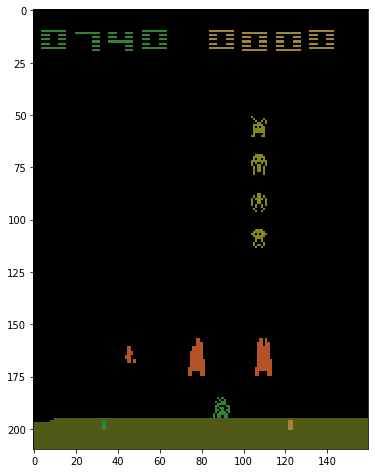

In [9]:
max_episodes = 3
i = 0

plt.figure(figsize = (6,9))
img = plt.imshow(env.render(mode='rgb_array'))

while i < max_episodes:
    
    observation = env.reset()
    score = 0
    done = False
    i += 1
    
    while not done:
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        with torch.no_grad():

            obs_n = torch.from_numpy(observation).float().to(device) / 255
            obs_n = obs_n.view(1, obs_n.shape[0], obs_n.shape[1], obs_n.shape[2])
            q_value = policy_network(obs_n)
            action = q_value.argmax(1).data.cpu().numpy().astype(int)[0]
        
        next_observation, reward, done, info = env.step(action_space[action])
        
        observation = next_observation

### Playing the game with a random agent to compare to the trained agents. 

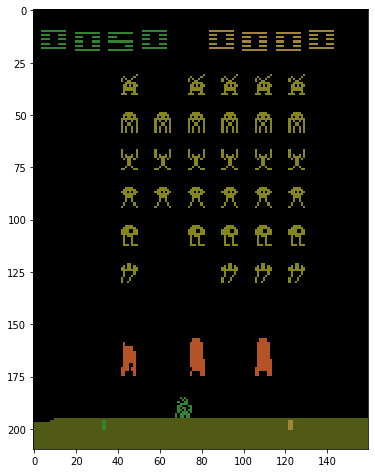

In [8]:
max_episodes = 10
i = 0

plt.figure(figsize = (6,9))
img = plt.imshow(env.render(mode='rgb_array'))

while i < max_episodes:
    
    observation = env.reset()
    score = 0
    done = False
    i += 1
    
    while not done:
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        action = random.sample(range(len(action_space)), 1)[0]
        
        next_observation, reward, done, info = env.step(action_space[action])
        
        observation = next_observation

#### The above games suggest that our trained agent playes better than a random agent (with more number of episodes).